# Faster R-CNN for Object Detection

### Setup

In [11]:
%load_ext autoreload
%autoreload 2

Import libraries.

In [12]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence

Check device.

In [13]:
#%% Use GPU
USE_GPU = True
#dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


### Load Images

A Pytorch Dataset class to load the Pascal-VOC images and their corresponding annotations. Pascal-VOC contains 20 Classes of Objects.

In [14]:
class ObjectDetectionDataset(Dataset):
    '''
    Returns:
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, image_path, img_dir, img_size, label_encoder, label_decoder, num_imgPclass, num_class):
        self.annotation_path = annotation_path
        self.image_path = image_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.label_encoder = label_encoder
        self.label_decoder = label_decoder
        self.num_imgPclass = num_imgPclass
        self.num_class = num_class
        
        self.sampled_idx = torch.from_numpy(np.random.choice(20, num_class, replace=False))
        self.sampled_class = {self.label_decoder[idx.item()]:0 for idx in self.sampled_idx}
        self.sampled_class_encoder = {self.label_decoder[value.item()]:idx for idx, value in enumerate(self.sampled_idx)}
        self.sampled_class_encoder['pad'] = -1
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
        
    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        
        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path,
                                                                   self.image_path,
                                                                   self.img_dir,
                                                                   self.img_size,
                                                                   self.num_imgPclass,
                                                                   self.sampled_class)
        
        for i, img_path in enumerate(img_paths):
            
            # skip if the image path is not valid
            #if (not img_path) or (not os.path.exists(img_path)):
            #    continue
                
            # read and resize image
            img = io.imread(img_path)
            img = resize(img, self.img_size)
            
            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            
            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.sampled_class_encoder[name] for name in gt_classes])
            
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
        
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

Set Hyper-parameters.

In [15]:
num_imgPclass = 100
num_class = 5
batch_size = 2
img_width = 640
img_height = 480
data_split_ratio = [0.8, 0.1, 0.1]

Build Dataset.

In [16]:
annotation_path = "C:\Stanford_2022_Autumn\CS330\Project\Dataset\VOCdevkit\VOC2012\Annotations"
image_path = "C:\Stanford_2022_Autumn\CS330\Project\Dataset\VOCdevkit\VOC2012\JPEGImages"
image_dir = os.path.join("data", "images")
label_encoder = {'pad': -1, 'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep':6,
                 'aeroplane': 7, 'bicycle': 8, 'boat': 9, 'bus': 10, 'car':11, 'motorbike': 12, 'train': 13,
                 'bottle': 14, 'chair':15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19}
label_decoder = {value:key for key, value in label_encoder.items()}

od_dataset = ObjectDetectionDataset(annotation_path,
                                    image_path, image_dir,
                                    (img_height, img_width),
                                    label_encoder,
                                    label_decoder,
                                    num_imgPclass,
                                    num_class)
print("Number of Images for Each Class (one image can contain objects from multiple classes):")
print(od_dataset.sampled_class)
print("\nTotal Number of Images: ")
print(len(od_dataset))

train_dataset, val_dataset, test_dataset = random_split(od_dataset, data_split_ratio)
print("\nNumber of Images for Training: ")
print(len(train_dataset))
print("\nNumber of Images for Validation: ")
print(len(val_dataset))
print("\nNumber of Images for Testing: ")
print(len(test_dataset))
print(od_dataset.sampled_class_encoder)

Number of Images for Each Class (one image can contain objects from multiple classes):
{'boat': 102, 'motorbike': 100, 'chair': 101, 'bicycle': 100, 'aeroplane': 100}

Total Number of Images: 
492

Number of Images for Training: 
394

Number of Images for Validation: 
49

Number of Images for Testing: 
49
{'boat': 0, 'motorbike': 1, 'chair': 2, 'bicycle': 3, 'aeroplane': 4, 'pad': -1}


Generate Dataloader.

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Display Example Images and Ground Truth Bounding Boxes

In [21]:
cur_encoder = od_dataset.sampled_class_encoder
cur_decoder = {value:key for key, value in cur_encoder.items()}

i = 1
index = 10 # 6,14,16
for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
    if i == index:
        img_data_all = img_batch
        gt_bboxes_all = gt_bboxes_batch
        gt_classes_all = gt_classes_batch
        break
    i += 1

print(img_data_all.shape)
print(gt_bboxes_all)
print(gt_classes_all)
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_classes_all = gt_classes_all[:2]

torch.Size([2, 3, 480, 640])
tensor([[[183.0400,  46.1261, 474.8800, 399.2793],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
         [ -1.0000,  -1.0000,  -1.0000,  -1.0000]],

        [[ 57.6000, 102.4000, 307.2000, 302.0800],


In [22]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [cur_decoder[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [cur_decoder[idx.item()] for idx in gt_class_2]

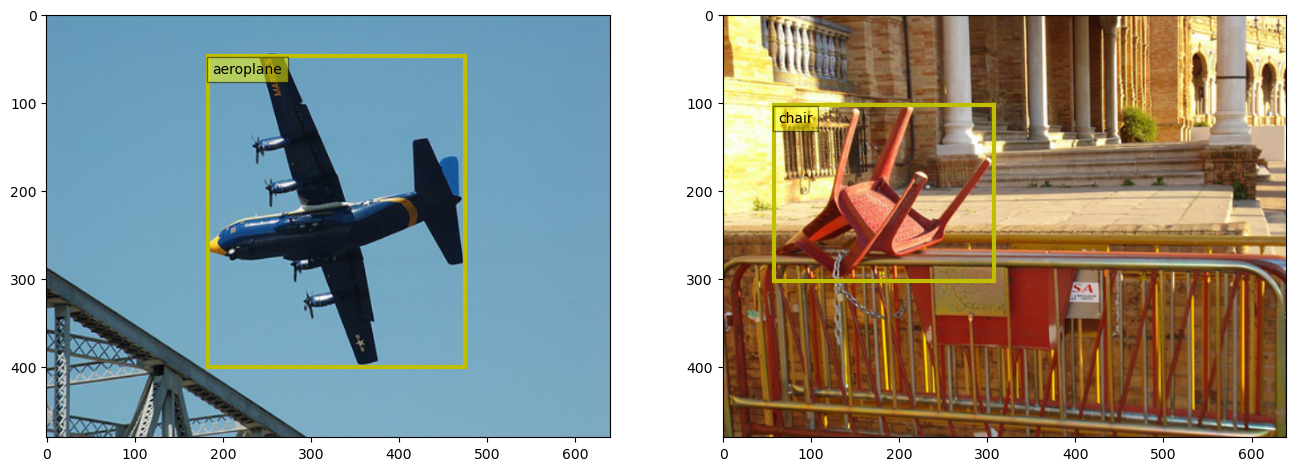

In [23]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

### Convolutional Backbone Network

use the first 4 layers of resnet50 as our convolutional backbone

In [29]:
model = torchvision.models.resnet50(weights=True)

In [25]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [26]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [27]:
# run the image through the backbone
out = backbone(img_data_all)

In [30]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [31]:
out_c, out_h, out_w

(2048, 15, 20)

Check how much the image has been down-scaled

In [32]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

### Visualize feature maps

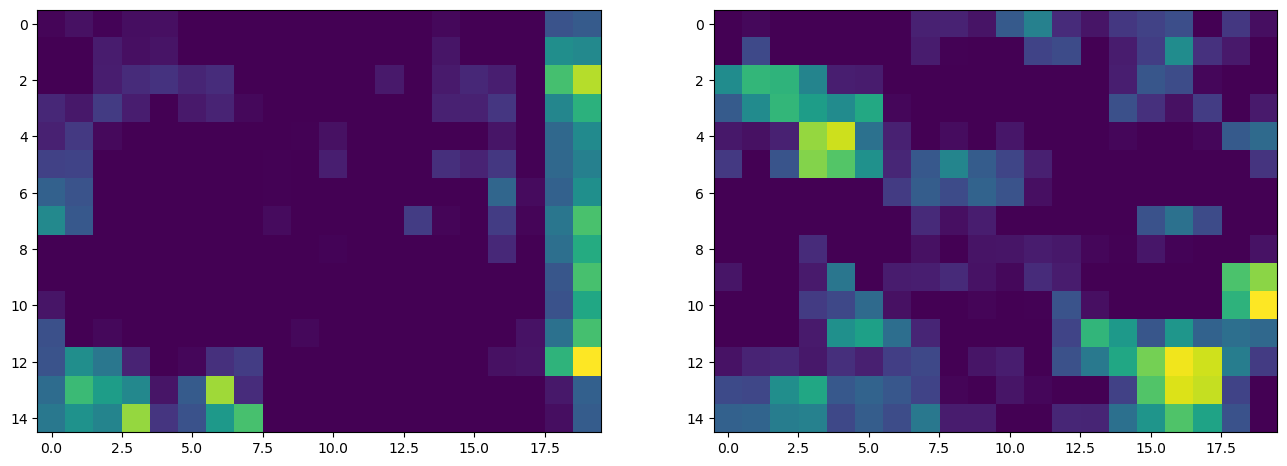

In [33]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data = [filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Visualize Anchor Points and Anchor Boxes

Each point in the feature map is an anchor point

In [34]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

In [35]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

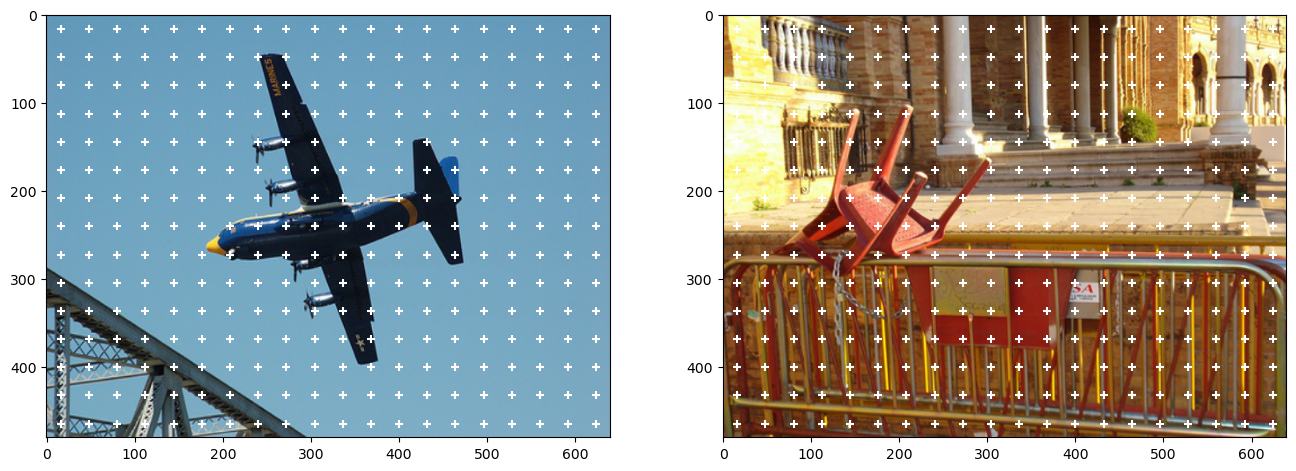

In [36]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

Create Anchor Boxes around Anchor points (nine boxes for each point)

In [37]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [38]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

plot anchor boxes on a single anchor point

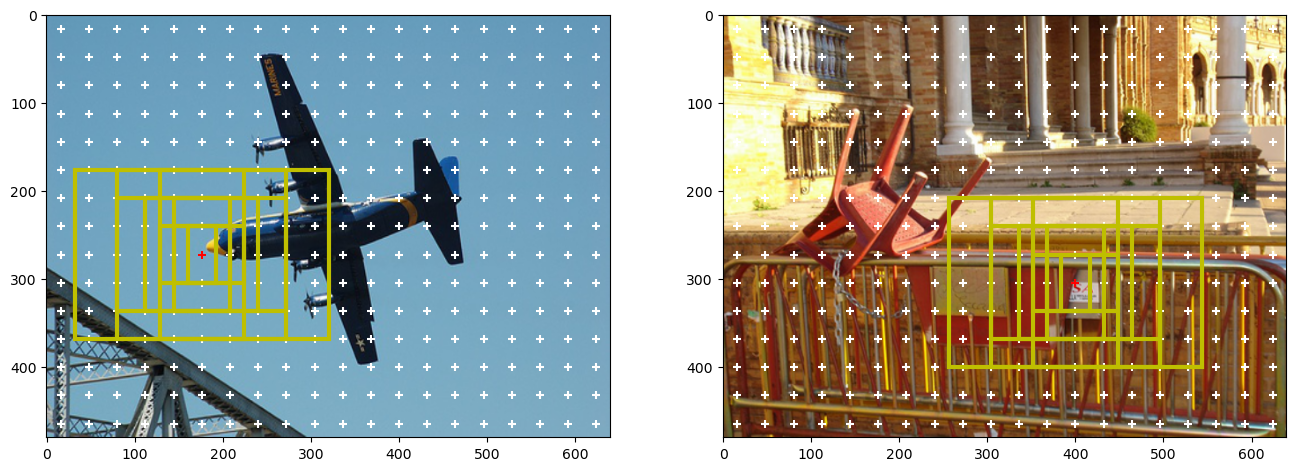

In [39]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

plot all anchor boxes

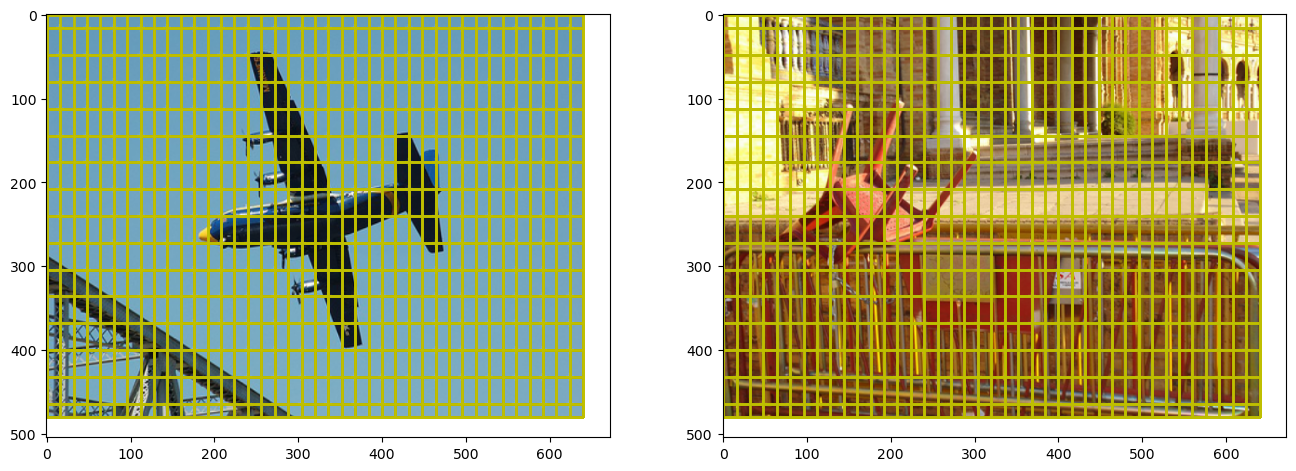

In [40]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [41]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [42]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

Visualize positive and negative anchor boxes

In [43]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

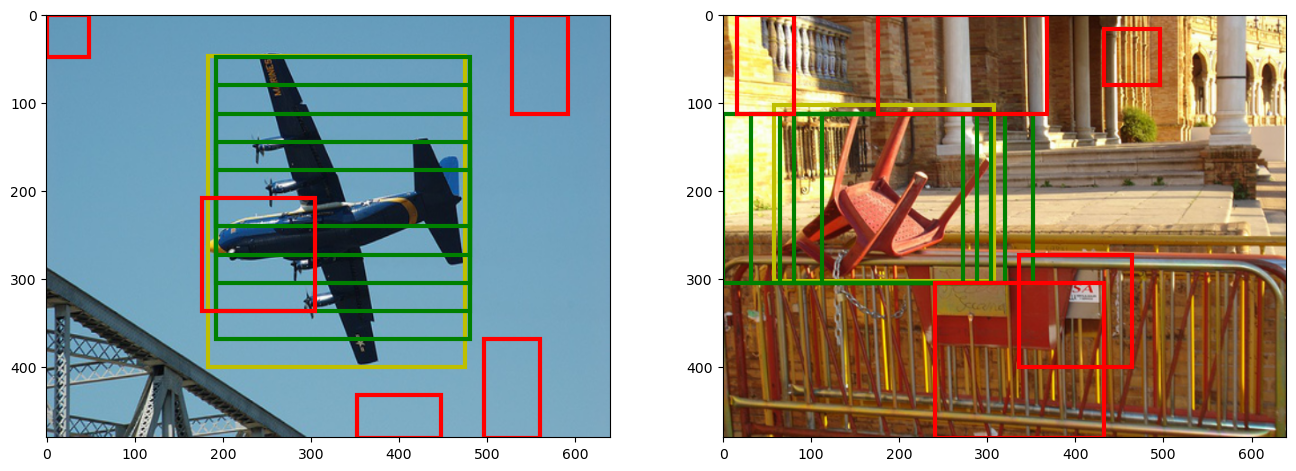

In [44]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

### Build the model

In [144]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, num_class, roi_size)

In [145]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

### Training

In [146]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_list.append(total_loss)
        
    return loss_list

In [148]:
learning_rate = 1e-3
n_epochs = 40

loss_list = training_loop(detector, learning_rate, train_dataloader, n_epochs)

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [3:40:40<00:00, 331.01s/it]


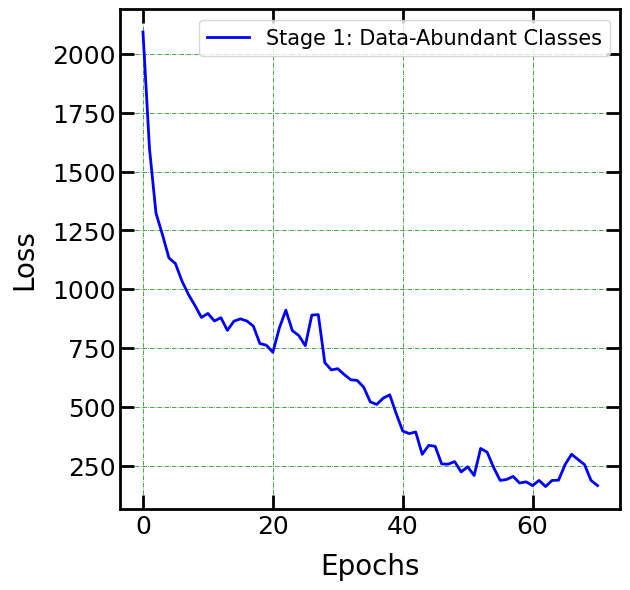

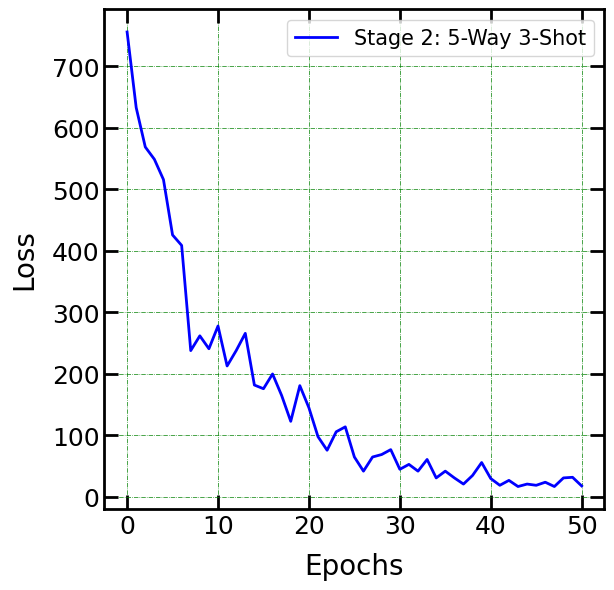

In [471]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans' # font
plt.rcParams['font.size'] = 18         # font size
plt.rcParams['axes.linewidth'] = 2     # axes width

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])    # Add axes object to our figure that takes up entire figure
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')
ax.plot(loss_list, linewidth=2, color='b', label="Stage 1: Data-Abundant Classes", alpha = 1)
ax.set_ylabel('Loss', labelpad=10, fontsize=20)
ax.set_xlabel('Epochs', labelpad=10, fontsize=20)
ax.grid(color='g', ls = '-.', lw = 0.5)
plt.legend(loc="upper right", fontsize=15)
plt.title("")
#plt.savefig('Faster R-CNN.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])    # Add axes object to our figure that takes up entire figure
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')
ax.plot(loss_list_s2, linewidth=2, color='b', label="Stage 2: 5-Way 3-Shot", alpha = 1)
ax.set_ylabel('Loss', labelpad=10, fontsize=20)
ax.set_xlabel('Epochs', labelpad=10, fontsize=20)
ax.grid(color='g', ls = '-.', lw = 0.5)
plt.legend(loc="upper right", fontsize=15)
plt.title("")
#plt.savefig('Faster R-CNN.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

Save model

In [150]:
torch.save(detector.state_dict(), "batchSize2_5w_100s.pt")

### Inference

In [10]:
i = 1
index = 3
for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
    if i == index:
        detector.eval()
        proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.98, nms_thresh=0.05)
        break
    i += 1

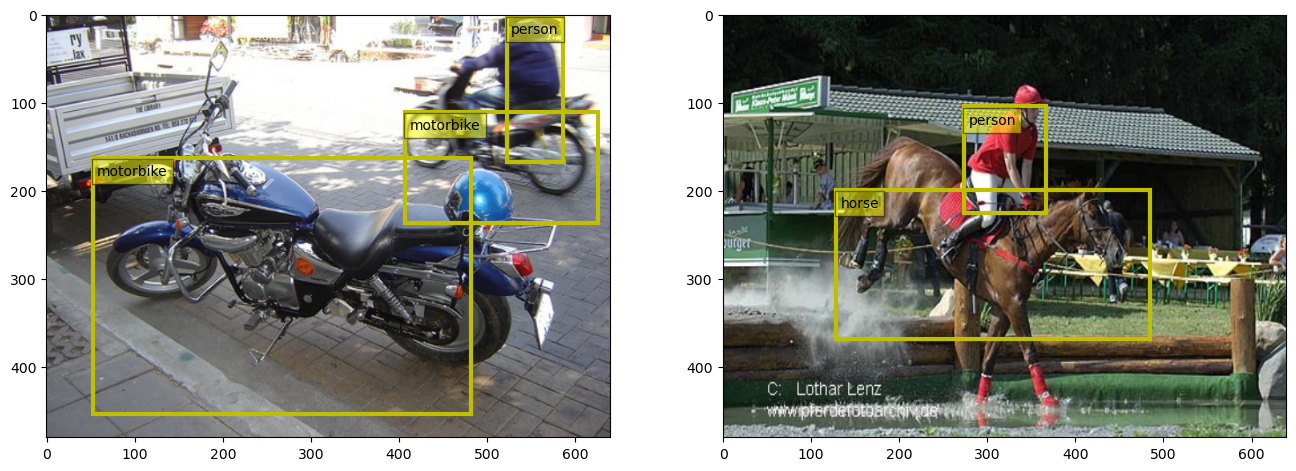

In [360]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [cur_decoder[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [cur_decoder[cls] for cls in classes_final[1].tolist()]

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)